Example Code Usage
==================
The following code is an example on how to use the framework presented in "The Role of Metabolism in Shaping Enzyme Structures Over 400 Million Years of Evolution" by Lemke and Heineike et. al as submitted to $Nature$. The presented analysis is based on a reduced orthogroup of CDC19 (P00549) in $Saccaromyces\ cerevisiae$ using the reference Structure downloaded from https://alphafold.ebi.ac.uk and the remaining 9 structures calculated for publication. From now on everything that comes below is a step by step example:

Example Setup for the Mapping
=============================
Import all packages and functions needed that are needed. The collections map_structures.py and color_dictionaries.py are available on GitHub. 
https://github.com/OliverLemke/structure_comparison/tree/main

In [1]:
import map_structures
import color_dictionaries
import pandas as pd
import os
import matplotlib.pyplot as plt

Define the input parameters for the mapping as well as parameters for the plotting functions. A more detailed description of the parameters is given in their respective functions.

In [2]:
### Parameters
# Distance cutoff for mapping (Angstrom)
dist_cut = 2
# Distance cutoff for binding site detection (Angstrom)
dist_cut_lig = 5
# Distance cutoff network (Angstrom)
dist_cut_network = 10
# Set number of neighbors to be taken into account for neighbor search
k = 100
# Ligands to be excluded for binding site detection
ligands_to_be_excluded = ["2HP","BA","CL","F","HG","K","LI","NA","NH4","PB","PO4","SO4","NO3","POP","ACE","AZI","HOH"]
# Which entries of the list should be read in?
index = 0

### Reproducibility
# Seed
seed = 42

### Representation
# Fontsize for figures
fontsize = 10
# Color for Matching residues (no mutation)
color_match = "#808B96"
# Color for "bad" values
bad_color = "#D0D0D0"

Define pathes for organized data storage and input files to be read in to initialize the calculations. It is advised to use absolute pathes (not applied in this example).

In [3]:
### Pathes
# Get current directory
cwd = os.getcwd()
# Set initial path proteins
initial_path_proteins = "Structures/"
initial_path_proteins = os.path.join(cwd,initial_path_proteins)
# Set initial path ligands, not provided for this example
initial_path_ligands = ""
initial_path_ligands = os.path.join(cwd,initial_path_ligands)
# Set output path data
output_path_indices = "Output/"
output_path_indices = os.path.join(cwd,output_path_indices)
output_path_summary = "Output/"
output_path_summary = os.path.join(cwd,output_path_summary)
output_path_vmd = "Output/"
output_path_vmd = os.path.join(cwd,output_path_vmd)
# Set output path figures
output_path_s = "Figures/"
output_path_s = os.path.join(cwd,output_path_s)

### Input Files
# Set File Mapping
file_mapping = "Mapping.tsv"
file_mapping = os.path.join(cwd,file_mapping)
# Set Ligand Mapping
ligand_mapping = ""
ligand_mapping = os.path.join(cwd,ligand_mapping)

Set flags to speed up calculations or circumvent more expensive functions. The binding site plot repeats most of the plots only for amino acids that are assigned to the binding site by the filtering cutoff. Regarding the binding site an automated handle is implemented that detects whether a ligand is present or not.

In [4]:
# Write output for mapped indices
write_output_indices = False
# Should secondary structure analysis be performed?
do_dssp = True
# Should solvent accessible surface area calculation be performed?
do_sasa = True
# Should plots be generated?
do_plots = True
# Should plots for the binding site be generated?
do_plots_binding_site = False

Reading in the inputs. The mapping files contain several columns:\
"Orthogroup": Group name of structures to be aligned\
"New directory": Directory in which structures are located\
"#1": Reference structure\
"#\\${n}": Structures that should be aligned. \\${n} denotes an index > 1 as an identifier

In [5]:
# Read Input Proteins
file_setup = pd.read_csv(file_mapping,sep="\t")
# Read Input Ligands: Not included for this example
# ligand_setup = pd.read_csv(ligand_mapping,sep="\t",index_col="New directory")
ligand_setup = []

Initialize the mapping by reading in all files for one line in the input and generate calculate molecular properties, which are saved in one dictionary. In each run only one line of the input is read in. To perform multiple mappings everything that follows can be included in a for loop varying the index.

In [6]:
if not index:
    index = 0

# Get Inputs. To provide a ligand_setup you need to provide a second file (see cell above) 
orthogroup, identifier, reference, files_proteins, files_ligands, ligands_exist = map_structures.get_Input(file_setup, ligand_setup = ligand_setup, initial_path_proteins = initial_path_proteins, initial_path_ligands = initial_path_ligands, index = index)

# Set dynamic output_path based for analysis with og name to circumvent problems with duplicates
output_path = output_path_s
# If multiple mappings are performed it is adviced to generate unique directories for every mapping. 
#output_path = os.path.join(output_path,identifier)

# Get Dictonaries
dict_atom_type, dict_colors, dict_boundaries, dict_amino_acids, dict_sasa_max = color_dictionaries.get_dictionaries()
dict_molecules = map_structures.get_Dictionary_Molecules(reference, files_proteins)
dict_molecules = map_structures.get_Dictionary_Molecular_Analysis(files_proteins, dict_molecules, do_dssp=do_dssp, do_sasa=do_sasa)
dict_molecules = map_structures.get_Dictionary_Proteins(dict_molecules)

/opt/anaconda3/envs/P39_basic/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


If a ligand exist, the ligand will be added to the dictionary.

In [7]:
# If ligand(s) are present get potentially coordinating residues
if ligands_exist:
    ligands, ligands_exist = map_structures.get_ligands(files_ligands, ligands_to_be_excluded=ligands_to_be_excluded, ligands_exist=ligands_exist)
    dict_molecules = map_structures.get_indices_residues_ligands(dict_molecules, ligands, dist_cut_lig = dist_cut_lig, k = k)

The following cell is the heart of the code as it performs the 1:1 mapping of the structures to the reference to obtain the basis for all upcoming comparisons. This cell creates two dictionaries containing the molecular informations projected onto the mapping as well as color coded for easier access and plotting.

In [8]:
# Map proteins
dict_mapping = map_structures.mapping_Proteins(dict_molecules, reference, dist_cut = dist_cut)
if write_output_indices:
    map_structures.write_indices_mapping(dict_molecules, dict_mapping, dist_cut = dist_cut, output_path_data = output_path_indices)
# Map residues
dict_mapping = map_structures.mapping_Characteristics(dict_molecules, dict_mapping, dict_atom_type, do_dssp = do_dssp, do_sasa = do_sasa)
# Map colors
dict_mapping_colors, ligands_exist = map_structures.mapping_colors(dict_mapping, dict_colors, dict_molecules, reference, color_match = color_match, bad_color = bad_color, ligands_exist = ligands_exist)

Generate the plots projecting different properties onto the mapping like DSSP or SASA. Also plots that show conserved amino acids with respect to the reference structure are created. Plots are saved to disc and closed automatically to save memory.

In [9]:
    for key in ["Amino Acid","Amino Acid reduced","Amino Acid Type","Amino Acid Type reduced","DSSP","DSSP reduced","SASA","pLDDT"]:
        if do_plots:
            map_structures.plot_Feature_comparison(key, dict_mapping, dict_mapping_colors, dict_boundaries, output_path=output_path, ligands_exist=ligands_exist, fontsize=fontsize, svg=False)
        if do_plots_binding_site and ligands_exist:
            map_structures.plot_Feature_comparison(key, dict_mapping, dict_mapping_colors, dict_boundaries, output_path=output_path, ligands_exist=ligands_exist, do_plots_binding_site=do_plots_binding_site, dict_molecules=dict_molecules, reference=reference, fontsize=fontsize, svg=False)

This is an example plot to highlight the conservation. The "bad" color highlights amino acids that could not be mapped.
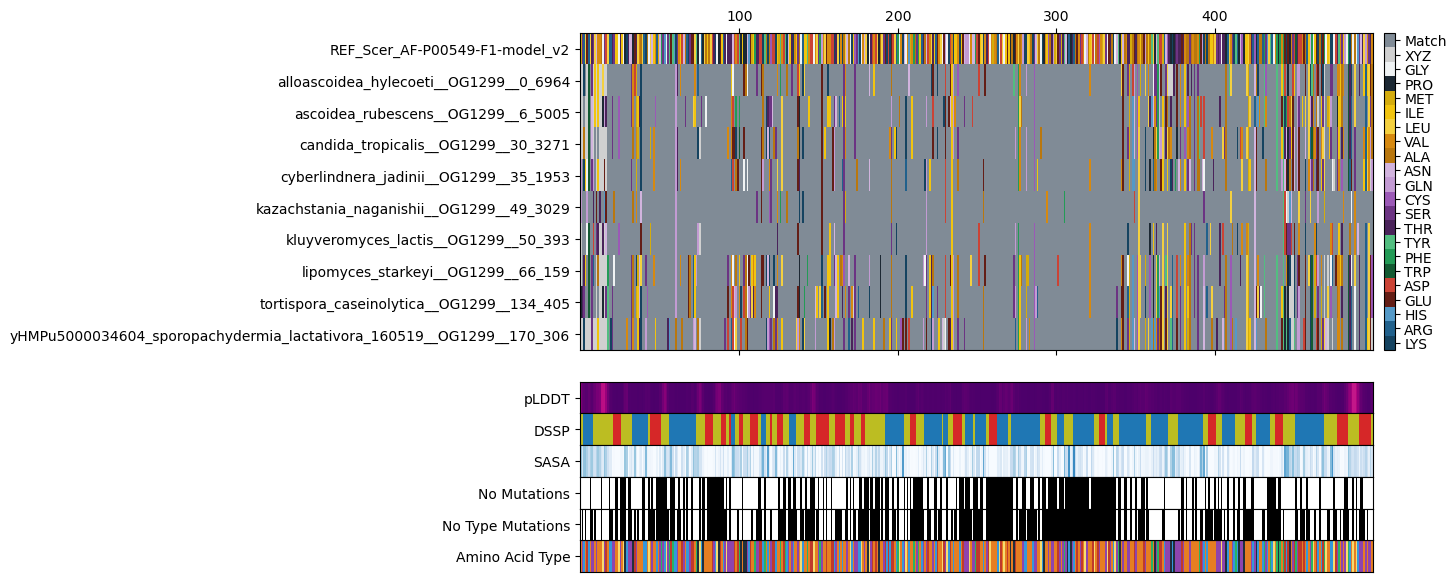

Perform the network clustering of fully conserved amino acids or amino acid types respectively. If write_vmd=True an input file for the software VMD (https://www.ks.uiuc.edu/Research/vmd/) is provided highlighting the clusters automatically. The file itself contains instructions how to call it. If no absolute pathes are used, it might be necessary to update the input and output pathes in the .tcl-file.

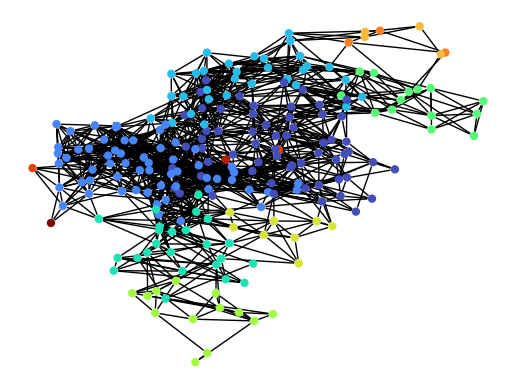

In [10]:
# Network clustering for fully conserved amino acids
if any(dict_mapping_colors["No Mutations"]==1):
    dict_mapping_colors = map_structures.get_clustered_network(dict_molecules, dict_mapping_colors, reference, key = "No Mutations", dist_cut=dist_cut_network, seed=seed, output_path=output_path, write_vmd=True, output_path_vmd=output_path_vmd, file_name_tcl=identifier+"_no_m.tcl", vmd_out=identifier+"_no_m", files_proteins=files_proteins, summarize=True)
# Network clustering for fully conserved amino acid types
#if any(dict_mapping_colors["No Type Mutations"]==1):
#    dict_mapping_colors = map_structures.get_clustered_network(dict_molecules, dict_mapping_colors, reference, key = "No Type Mutations", dist_cut=dist_cut_network, seed=seed, output_path=output_path, write_vmd=True, output_path_vmd=output_path_vmd, file_name_tcl=identifier+"_no_tm.tcl", vmd_out=identifier+"_no_tm", files_proteins=files_proteins, summarize=True)

This is an example how to molecular display of the network clustering will look like using VMD 1.9.4. VMD is developed with NIH support by the Theoretical and Computational Biophysics group at the Beckman Institute, University of Illinois at Urbana-Champaign.

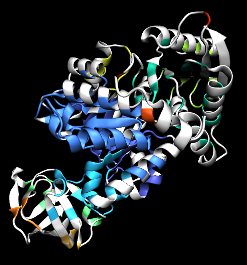

Finally, all the output needs to be saved.

In [11]:
# Write output to file
map_structures.write_output(dict_molecules, dict_mapping,dict_mapping_colors, reference, output_path_data=output_path_summary)

At this point the mapping and network calculations are finished. Everything that comes below this block are some examples how to extract data from this selection without the use of external data sources.

Example Analysis of the Mapping
===============================
The two most straightforward properties are the conservation ratio and the mapping ratio. This analysis is based on the fact that for the color mapping for the amino acid residues that could not be mapped a 20 is assigned. For amino acids that are similar to the reference structure a 21 is assigned. Thus, the mean conservation and mapping ratio can be calculated as follows:

In [12]:
import numpy as np

# For the following calculations the row with index 0 is neglected as it contains the reference structure
# Mapping ratio
mapping_ratio = np.mean((np.sum((dict_mapping_colors["Mapping Amino Acid reduced"] != 20).astype(int), axis=1)/
                         np.shape(dict_mapping_colors["Mapping Amino Acid reduced"])[1])[1:])
# Conservation ratio
# The normalization takes only into account what can be mapped
conservation_ratio = np.mean((np.sum((dict_mapping_colors["Mapping Amino Acid reduced"] == 21).astype(int), axis=1)/
                              np.sum((dict_mapping_colors["Mapping Amino Acid reduced"] != 20).astype(int), axis=1))[1:])

print("The mapping ratio is {:.2f}".format(mapping_ratio))
print("The conservation ratio is {:.2f}".format(conservation_ratio))

The mapping ratio is 0.98
The conservation ratio is 0.75


To subset the structure also selections that account for certain regions within the protein, e.g. the surface or the core or secondary structural elements can be defined:

In [13]:
# Split core and surface
sasa_cut = 0.25
# Get corresponding dictionaries
dict_sasa_max = color_dictionaries.get_dictionaries()[4]

# Binding site extracted from https://www.uniprot.org/uniprotkb/P00549/entry
binding_site = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
                0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Define subsets. Always be sure to account for "bad" i.e. not mapped values.
dict_selection = {"Mapped": dict_mapping["Amino Acid"] != "XYZ",
                  "Inner": ((dict_mapping["SASA"]/
                             np.vectorize(dict_sasa_max.get)(dict_mapping["Amino Acid"])) < sasa_cut) & (dict_mapping["SASA"] != -1),
                  "Outer": ((dict_mapping["SASA"]/
                             np.vectorize(dict_sasa_max.get)(dict_mapping["Amino Acid"])) >= sasa_cut) & (dict_mapping["SASA"] != -1),
                  "Helical": dict_mapping["DSSP"] == "H",
                  "Extended": dict_mapping["DSSP"] == "E",
                  "Random Coil": dict_mapping["DSSP"] == "C",
                  "Binding Site": np.logical_and(np.asarray([binding_site]*len(dict_mapping["Amino Acid"])).astype(bool),
                                                 dict_mapping["Amino Acid"] != "XYZ")
                 }

# Generate metrics or properties:
for key,value in dict_selection.items():
    cr_tmp = np.sum((dict_mapping_colors["Mapping Amino Acid reduced"][value] == 21).astype(int))/(np.sum(value.astype(int))-np.sum(value[0]))
    print("The conservation ratio of the "+key+" region is {:.2f}".format(cr_tmp))
       

The conservation ratio of the Mapped region is 0.75
The conservation ratio of the Inner region is 0.82
The conservation ratio of the Outer region is 0.64
The conservation ratio of the Helical region is 0.71
The conservation ratio of the Extended region is 0.79
The conservation ratio of the Random Coil region is 0.77
The conservation ratio of the Binding Site region is 0.96


Also extracting the amino acid content is straight forward:

In [14]:
# Define amino acids
amino_acids = ["ALA", "CYS", "ASP", "GLU", "PHE", "GLY", "HIS", "ILE", "LYS",
               "LEU", "MET", "ASN", "PRO", "GLN", "ARG", "SER", "THR", "VAL", 
               "TRP", "TYR"]

# For this example only for the mapped region
key = "Mapped"

dict_content = {}
for amino_acid in amino_acids:
    dict_content.update({amino_acid:
                        len([residue for residue in dict_mapping["Amino Acid"][dict_selection[key]] if residue == amino_acid])/
                        len(dict_mapping["Amino Acid"][dict_selection[key]])})

aa_pick = "ALA"
print("The content of amino acid "+aa_pick+" in the "+key+" region is {:.2f}".format(dict_content[aa_pick]))

The content of amino acid ALA in the Mapped region is 0.08
